In [1]:
# Libraries

import argparse
import matplotlib
import numpy
import os
import json
import torch
import platform
import seaborn
import shutil
import sys

In [2]:
# Ensure source path

ROOT = os.getcwd()

while not ROOT.endswith('upolanc-thesis') :
	ROOT = os.path.abspath(os.path.join(ROOT, os.pardir))

	if len(ROOT) < len('upolanc-thesis') :
		if   platform.system() == 'Linux'   : ROOT = '/d/hpc/projects/FRI/up4472/upolanc-thesis'
		elif platform.system() == 'Windows' : ROOT = 'C:\\Developer\\Workspace\\PyCharm\\Projects\\upolanc-thesis'
		else : raise ValueError()

		print(f'Warning : could not find correct directory, using default : {ROOT}')
		print()

		break

if ROOT not in sys.path :
	sys.path.append(ROOT)

os.chdir(ROOT)

In [3]:
# Code

from source.python.cnn.models import Washburn2019r
from source.python.cnn.models import Washburn2019c
from source.python.cnn.models import Zrimec2020r
from source.python.cnn.models import Zrimec2020c

from source.python.cnn      import cnn_motifs
from source.python.encoding import onehot
from source.python.io       import loader
from source.python          import runtime

runtime.set_numpy_format()
runtime.set_pandas_format()
runtime.set_plot_theme()

# 1. Setup

In [4]:
# Define output and inputs

FILTER_ID            = 3
MODEL_ARCH           = 'zrimec'
MODEL_MODE           = 'classification'

SEQUENCE_RANGE       = [50, 250]

NUCLEOTIDE_ALPHABET  = 'dna'
NUCLEOTIDE_ORDER     = 'ACGT'
NUCLEOTIDE_STRANDS   = '+ -'
NUCLEOTIDE_VALUE     = 'fraction'

DISPLAY_MOTIFS       = 'probability'
DISPLAY_COLS         = 8
DISPLAY_ROWS         = 4
DISPLAY_SIZE         = [(16, 10), (16, 16)]

ACTIVATION_WEIGHTED  = True
ACTIVATION_THRESHOLD = [0, numpy.PINF]

In [5]:
# Check for args

if __name__ == '__main__' and 'get_ipython' in dir() :
	print('Running as .ipynb')
	print()

if __name__ == '__main__' and 'get_ipython' not in dir() :
	print('Running as .py')
	print()

Running as .ipynb



In [6]:
# Setup some directory paths.

FILTER = 'filter' + str(FILTER_ID)
FOLDER = '{}-f{}-{}-{}'.format(
	MODEL_ARCH,
	FILTER_ID,
	MODEL_MODE[0],
	NUCLEOTIDE_VALUE
)

if ACTIVATION_WEIGHTED : FOLDER = FOLDER + '-weight'
else                   : FOLDER = FOLDER + '-counts'

CWD       = ROOT
OUT       = os.path.join(CWD, 'output')
OUT_DATA  = os.path.join(OUT, 'nbp15-motifs',  FOLDER)
RES_NBP04 = os.path.join(OUT, 'nbp04-feature', FILTER)

shutil.rmtree(OUT_DATA, ignore_errors = True)

os.makedirs(OUT_DATA, exist_ok = True)

print(f'     Root Directory : {CWD}')
print(f'   Output Directory : {OUT_DATA}')
print(f' Resource Directory : {RES_NBP04}')
print()

     Root Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis
   Output Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp15-motifs\zrimec-f3-c-fraction-weight
 Resource Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp04-feature\filter3



In [7]:
# Print

print('Sequence Bot Index       : {}'.format(SEQUENCE_RANGE[0] if SEQUENCE_RANGE is not None else None))
print('Sequence Top Index       : {}'.format(SEQUENCE_RANGE[1] if SEQUENCE_RANGE is not None else None))
print('Nucleotide Alphabet      : {}'.format(NUCLEOTIDE_ALPHABET))
print('Nucleotide Strands       : {}'.format(NUCLEOTIDE_STRANDS))
print('Nucleotide Order         : {}'.format(NUCLEOTIDE_ORDER))
print('Nucleotide Value         : {}'.format(NUCLEOTIDE_VALUE))
print('Motif Display            : {}'.format(DISPLAY_MOTIFS))
print('Activation Weighted      : {}'.format(ACTIVATION_WEIGHTED))
print('Activation Bot Threshold : {}'.format(ACTIVATION_THRESHOLD[0]))
print('Activation Top Threshold : {}'.format(ACTIVATION_THRESHOLD[1]))
print()

Sequence Bot Index       : 50
Sequence Top Index       : 250
Nucleotide Alphabet      : dna
Nucleotide Strands       : + -
Nucleotide Order         : ACGT
Nucleotide Value         : fraction
Motif Display            : probability
Activation Weighted      : True
Activation Bot Threshold : 0
Activation Top Threshold : inf



In [8]:
# System and device

DEVICE = runtime.get_device(only_cpu = False)
SYSTEM = runtime.get_system_info()

for key, value in SYSTEM.items() :
	print('{:25s} : {}'.format(key, value))

print()

platform/python           : 3.10.7
platform/system           : Windows
platform/release          : 10
platform/version          : 10.0.19045
platform/cpu/name         : N/A
platform/cpu/count        : 12
platform/gpu/name         : NVIDIA GeForce RTX 3060 Ti
platform/gpu/available    : True
platform/gpu/count        : 1
platform/memory/total     : 31.924 GB
platform/memory/available : 15.300 GB



In [9]:
# Define sequence paths

sequence_keep = os.path.join(RES_NBP04, 'sequences-2150-keep.fasta')
sequence_drop = os.path.join(RES_NBP04, 'sequences-2150-drop.fasta')
mutation_keep = os.path.join(RES_NBP04, 'mutation-sequences-2150.fasta')

In [10]:
#

sequence_keep = loader.load_fasta(
	filename  = sequence_keep,
	to_string = True
)

sequence_drop = loader.load_fasta(
	filename  = sequence_drop,
	to_string = True
)

mutation_sequence = loader.load_fasta(
	filename  = mutation_keep,
	to_string = True
)

if SEQUENCE_RANGE is not None : sequence = list(sequence_keep.values())[SEQUENCE_RANGE[0]:SEQUENCE_RANGE[1]]
else                          : sequence = list(sequence_keep.values())

# 2. Model

In [11]:
# Load model

if MODEL_ARCH == 'zrimec'   : models_path = '{}2020{}-best.pth'.format(MODEL_ARCH, MODEL_MODE[0])
if MODEL_ARCH == 'washburn' : models_path = '{}2019{}-best.pth'.format(MODEL_ARCH, MODEL_MODE[0])

folder_path = '{}-f{}-{}'.format(MODEL_ARCH, FILTER_ID, MODEL_MODE[0])

folder_path = os.path.join(OUT, 'nbp07-switch',  folder_path)
models_path = os.path.join(folder_path, 'model', models_path)
config_path = os.path.join(folder_path, 'config.json')

print(' Model Path : {}'.format(models_path))
print('Config Path : {}'.format(config_path))
print()

with open(config_path, mode = 'r') as handle :
	CONFIG = json.load(handle)

if MODEL_ARCH == 'zrimec' :
	if MODEL_MODE[0] == 'c' : model = Zrimec2020c(params = CONFIG, binary = True)
	if MODEL_MODE[0] == 'r' : model = Zrimec2020r(params = CONFIG)

	print(model.summary(
		batch_size  = CONFIG['dataset/batch/train'],
		in_height   = CONFIG['model/input/height'],
		in_width    = CONFIG['model/input/width'],
		in_features = CONFIG['model/input/features'],
	))

if MODEL_ARCH == 'washburn' :
	if MODEL_MODE[0] == 'c' : model = Washburn2019c(params = CONFIG, binary = True)
	if MODEL_MODE[0] == 'r' : model = Washburn2019r(params = CONFIG)

	print(model.summary(
		batch_size  = CONFIG['dataset/batch/train'],
		in_channels = CONFIG['model/input/channels'],
		in_height   = CONFIG['model/input/height'],
		in_width    = CONFIG['model/input/width'],
		in_features = CONFIG['model/input/features'],
	))

print()

 Model Path : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp07-switch\zrimec-f3-c\model\zrimec2020c-best.pth
Config Path : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp07-switch\zrimec-f3-c\config.json

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
Zrimec2020c                              [64, 4, 2150]             [64, 1]                   --
├─Zrimec2020: 1-1                        [64, 4, 2150]             [64, 512]                 --
│    └─Conv1d: 2-1                       [64, 4, 2150]             [64, 256, 2150]           5,376
│    └─LeakyReLU: 2-2                    [64, 256, 2150]           [64, 256, 2150]           --
│    └─BatchNorm1d: 2-3                  [64, 256, 2150]           [64, 256, 2150]           512
│    └─Dropout: 2-4                      [64, 256, 2150]           [64, 256, 2150]           --
│    └─MaxPool1d: 2-5                    [64, 256, 2150]           [64, 256, 

In [12]:
# Load state dict and convert to double

model.load_state_dict(
	torch.load(models_path)['models']
)

model = model.double()

# 3. Motifs

In [13]:
# Get convolutional layers and generate one hot encoding mapping

data = cnn_motifs.get_conv_layers_from_model(
	model = model
)

mapping = onehot.generate_onehot_mapping(
	nucleotide_order = NUCLEOTIDE_ORDER,
	ambiguous_value  = NUCLEOTIDE_VALUE
)

In [14]:
# Compute kernel activations (pretty slow ~ can be up to 12h)
# 256 filters, 5x4 kernels,    50 sequences ~   2 min
# 256 filters, 5x4 kernels, 20000 sequences ~ 800 min

ker_activations = cnn_motifs.get_kernel_activations(
	sequences = sequence,
	mapping   = mapping,
	layer     = data['layer'][0],
	device    = DEVICE,
	weighted  = ACTIVATION_WEIGHTED,
	threshold = ACTIVATION_THRESHOLD,
	function  = (
		'leaky_relu', {
		'negative_slope' : CONFIG['model/leakyrelu'],
		'inplace'        : True
	})
)

pos_activations = cnn_motifs.get_position_activations(
	sequences = sequence,
	mapping   = mapping,
	layer     = data['layer'][0],
	device    = DEVICE,
	fn        = numpy.mean,
	function  = (
		'leaky_relu', {
		'negative_slope' : CONFIG['model/leakyrelu'],
		'inplace'        : True
	})
)

ker_activations = {i : x for i, x in enumerate(ker_activations)}

Filters : 256
Width   : 5
Height  : 4



Minimum Value : 0.22991
Maximum Value : 0.27601



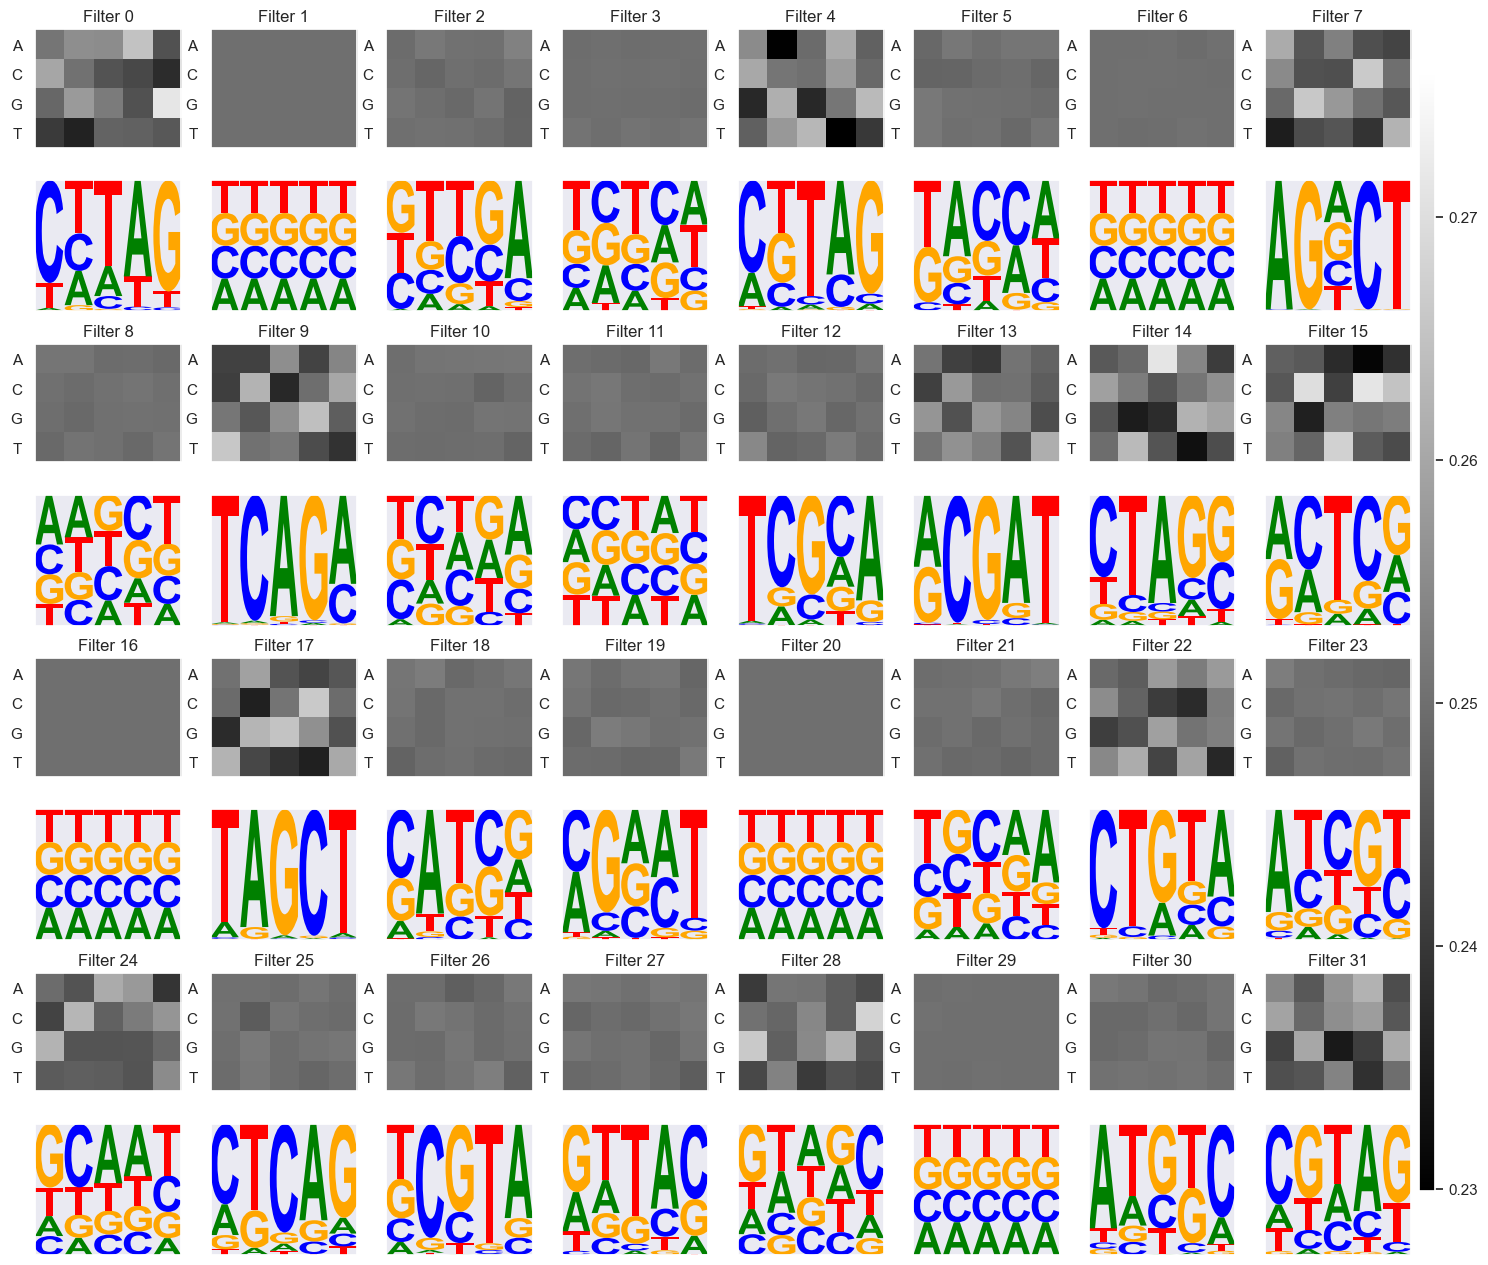

In [15]:
# Plot kernels and motifs

motifs = cnn_motifs.plot_kernels_and_motifs(
	weights          = data['weight'][0].squeeze(),
	activations      = ker_activations,
	to_type          = DISPLAY_MOTIFS,
	nucleotide_order = NUCLEOTIDE_ORDER,
	filename         = os.path.join(OUT_DATA, 'activation-kernel-motif'),
	cols             = DISPLAY_COLS,
	rows             = DISPLAY_ROWS,
	figsize          = DISPLAY_SIZE[1]
)

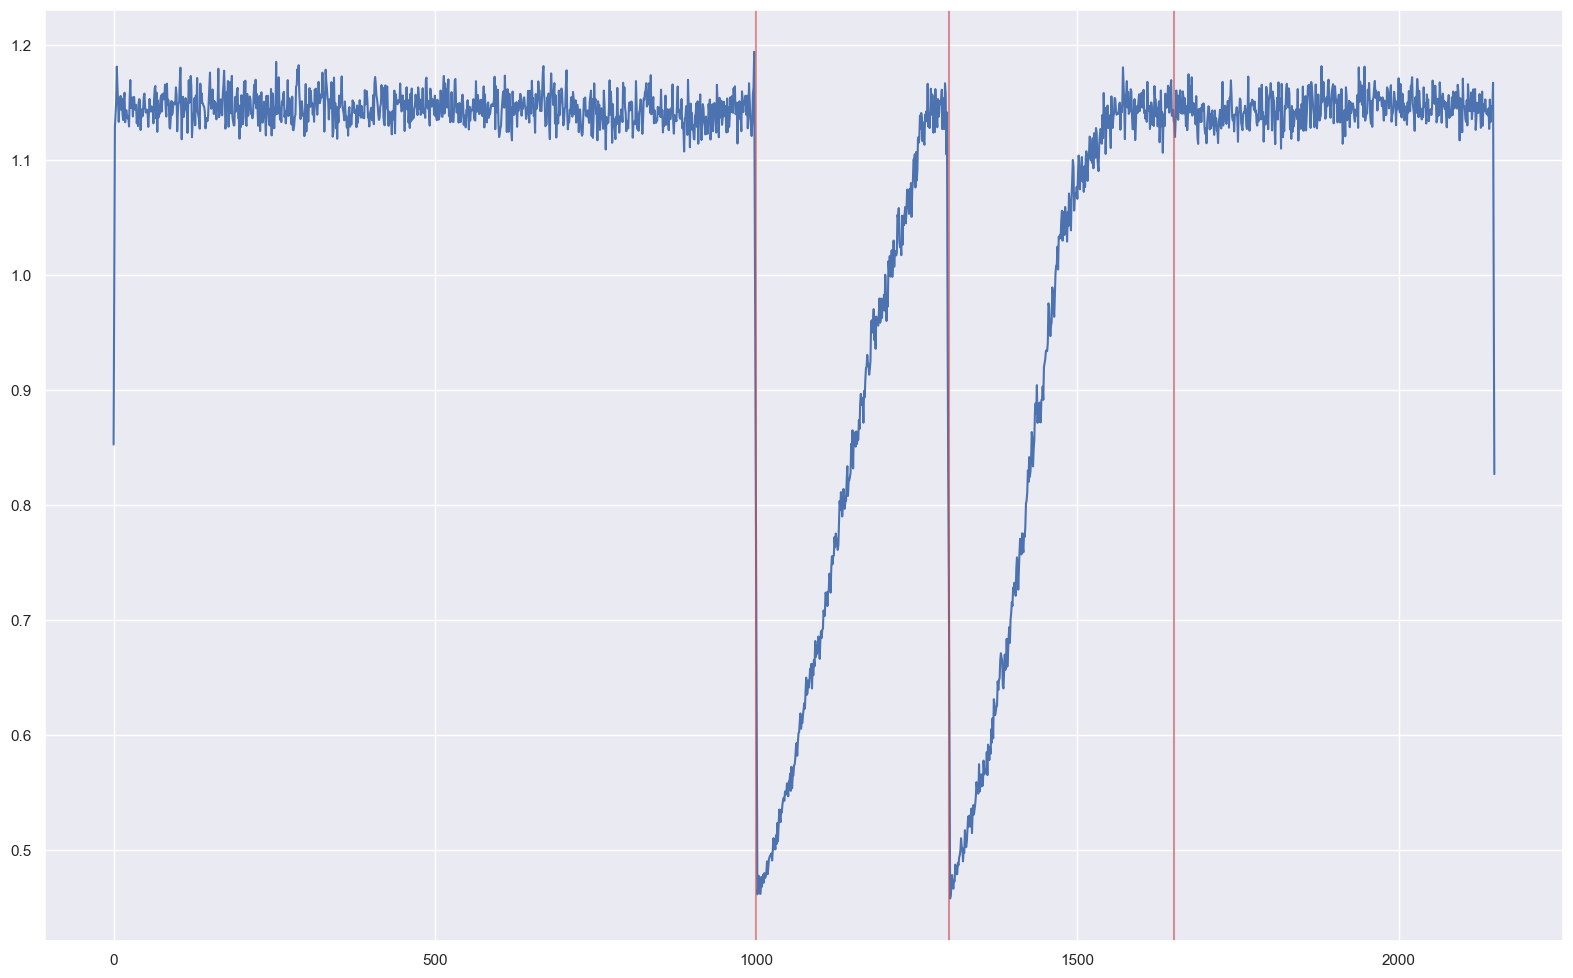

In [16]:
# Plot position activations

import matplotlib
import seaborn

fig, ax = matplotlib.pyplot.subplots(figsize = (16, 10))
fig.tight_layout()

seaborn.lineplot(pos_activations, ax = ax)
matplotlib.pyplot.axvline(1000, color = 'r', alpha = 0.6)
matplotlib.pyplot.axvline(1300, color = 'r', alpha = 0.6)
matplotlib.pyplot.axvline(1650, color = 'r', alpha = 0.6)

matplotlib.pyplot.savefig(
	os.path.join(OUT_DATA, 'positional-ctivation.png'),
	dpi         = 120,
	format      = 'png',
	bbox_inches = 'tight',
	pad_inches  = 0
)

# 4. Save

In [17]:
# Compute background letter frequency (keep only the alphabet ones)

frequency = cnn_motifs.get_alphabet_letter_frequency(
	sequences      = sequence,
	to_probability = True,
	alphabet       = NUCLEOTIDE_ORDER
)

for k, v in frequency.items() :
	print('{:s} : {:.5f}'.format(k, v))

print('{:s} : {:.5f}'.format('-', sum(frequency.values())))
print()

A : 0.32286
T : 0.32577
C : 0.17821
G : 0.17317
- : 1.00000



In [18]:
# Save motifs to meme format

cnn_motifs.to_meme_format(
	motifs    = motifs,
	frequency = frequency,
	filename  = os.path.join(OUT_DATA, 'motifs'),
	strands   = NUCLEOTIDE_STRANDS,
	alphabet  = NUCLEOTIDE_ORDER,
	version   = 4
)

Using version     : 4
Using alphabet    : ACGT
Using strands     : + -
Using frequencies : A 0.32 T 0.33 C 0.18 G 0.17

Saved MEME formatted motifs : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp15-motifs\zrimec-f3-c-fraction-weight\motifs.meme

